 # Using Clustering Techniques to Determine the Location of a New Service Station

Using taxi rank locations in Johannesburg, South Africa we want to define key clusters of these locations and use that to determine where we could build service stations for all taxis operating in this region. An example of a taxi rank would be an airport or a bus station. Ideally we want a location to build the service station that will serve the most amount of taxis. 

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
!{sys.executable} -m pip install hdbscan

import sys
!{sys.executable} -m pip install folium

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

 ### After loading the data I will remove any duplicate taxi ranks and then use a scatter plot to show the locations of these ranks


In [3]:
df = pd.read_csv('taxi_data.csv')

In [4]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [5]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [6]:
df.isna().values.any()

True

In [7]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)

print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [8]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [9]:
X = np.array(df[['LON', 'LAT']], dtype='float64')

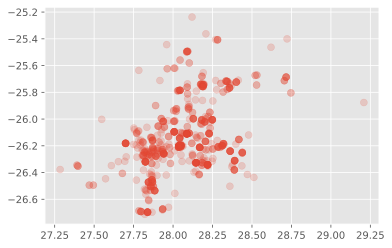

In [10]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

Now using Folium I will create a map showing the locations of the taxi ranks around the Johannesburg area 

In [11]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
#iterate each data point onto map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z]+', '', row.NAME), #this is used when strings havent been cleaned to prevent any issues when converting to javascript / html
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

In [12]:
m

### Firstly I will attempt to use the k means clustering algorithm

In [16]:
X =np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17, n_init=10).fit(X)
#random_state=17 ensures the same centroids are initialised when running this notebook, allowing the results to be the same
#n_init defines the number of times that the algorithm will run with different initial centroids, returning the best result
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [17]:
df.tail()

,LON,LAT,NAME,CLUSTER_kmeans70
832,28.04441,-26.19727,Zimbabwe Taxi Rank,13
833,27.82999,-26.24445,Zola Clinic Taxi Rank,14
834,27.83991,-26.24235,Zola Taxi Rank,14
835,27.86166,-26.23624,Zondi Taxi Rank,42
836,28.39097,-26.30931,kwaThema Taxi Rank,48


In [18]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return  m 

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6527069282371452


Silhoutte scores are used to evaluate the model, a perfect model will have a silhouette score of 1

In [ ]:
m

To determine the best value for k

In [19]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 250)):
    model = KMeans(n_clusters=k, random_state=1, n_init=10).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [01:59<00:00,  2.08it/s]

K=220
Silhouette Score: 0.7598401611088578


220 clusters is a lot for 836 data points so I will used DBSCAN instead and then come back to this if necessary.

# DBSCAN 

In [ ]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])


In [ ]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X) #eps is the max distance between two points for them to be considered in the same cluster 
#min samples is the minimum number of points within eps that are required for the region to be classified as a cluster 
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

df.tail()

'-1' means that this point is being classified as an outlier. 

I will assign all outliers to a singleton cluster by using a conditional statement below. The statement will create an index for class_predictions. If x=-1 (ie the point is an outlier), the code will find the index of that element in class_predictions and add 2 and then multiple by -1

This way I can evaluate the influence of outliers on the performance of the clustering.

In [ ]:
m = create_map(df, 'CLUSTERS_DBSCAN')


print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

#assign all clusters to a new cluster label, if the element '-1' is a position i of classpredictions then the new label will
#be 
#counter+2 ensures that  

There is a big difference in the silhouette scores which indicates that the outliers have a strong influence on the clusters and maybe we should look at ways to deal with the outliers.

In [ ]:
m

There are limitations to DBSCAN. The main one being that DBSCAN has a global understanding of density in a data set. Therefore it cannot pick up different kind of densities in a data set. DBSCAN also picks out outliers. I want all points to be clustered so next I will look at HDBSCAN. 

### HDBSCAN

In [20]:
model = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=0.01, min_samples=2)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [21]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504357342629
Silhouette outliers as singletons: 0.6389924833467704


So HDBSCAN has found less clusters and fewer outliers than DBSCAN

Now I need to deal with the remaining outliers. I will use K-nearest neighbor approach. 

In [22]:
classifier = KNeighborsClassifier(n_neighbors=1) #assign the outlier to its nearest cluster

In [23]:
#split the datadrame to train the classifier on clusters assigned using hdbscan

df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [24]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [25]:
classifier.fit(X_train, y_train) #fit the classifier to the training data

KNeighborsClassifier(n_neighbors=1)

In [26]:
predictions = classifier.predict(X_predict) #make predictions for the outliers

In [27]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [28]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions #if cluster_hdbscan is -1 then update value to predictions

In [29]:
m = create_map(df, 'CLUSTER_hybrid') 

In [30]:
m

In [31]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494876303


Text(0.5, 0, 'Cluster sizes')

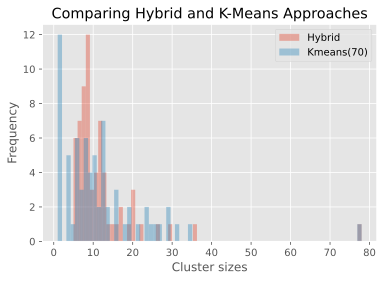

In [32]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, label='Hybrid')

df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4, label='Kmeans(70)')

plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster sizes')

Generally the hybrid approach has larger clusters. This means the clusters are richer and gives us more understanding on where to position the taxi service centers.

For this data set, it is better to use the hybird approach discussed above.

In conclusion it would be best to use a hybrid approach of first using HDBSCAN to find clusters and then use KNN to classify the outliers. Once we have the clusters we could use this information to build a service station in the center of this cluster to best serve taxis in that location. 